In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

# Helper functions......    

def open_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
        
    def add_fhour(ds):
        filename = ds.encoding["source"].split(".nc")
           
        init_time = 0
        fhour     = int(filename[0][-2:])
                
        ds.coords['fhour']     = fhour
        ds.coords['init_time'] = init_time

    filelist = os.path.join(data_dir,pattern)
 #   return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

    return xr.open_mfdataset(filelist,parallel=True)




In [2]:
def get_profiles(run_dir):
    
    cm1 = open_mfdataset_list(run_dir,  "cm1out_00000*.nc")

    cref = (cm1.dbz.values).max(axis=1)

    mask_cref = np.where(cref >= cref_min, True, False)

    mask_p = np.where(cm1.prs <= 70000., True, False)

    mask_w = np.where(cm1.winterp > w_min, True, False)

    mask_w_p = mask_p & mask_w

    mask_w_p_2d = np.any(mask_w_p, axis=1)

    mask_final =  mask_w_p_2d & mask_cref

    # print(np.sum(mask_p), np.sum(mask_w), np.sum( mask_w_p), np.sum(mask_final))
    # print(mask_final.shape)

    wlist = []
    for n in np.arange(7):
        mask = mask_final[n]
        if np.sum(mask) > 0:
            data = cm1.winterp[n,:,:,:].values[:,mask]
            wlist.append(data)
#
    wprofile = np.hstack(wlist[:])
    print("Shape of wprofile:  ",wprofile.shape)
    
    return wprofile, cm1.zh
    

In [9]:
w_min = 5.0
cref_min = 35.

input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'

run_dir = str(os.path.join(input_dir, 'squall_q16_s12'))

wprofile_q14, zh_q14 = get_profiles(str(os.path.join(input_dir, 'squall_q14_s12')))
wprofile_q11, zh_q14 = get_profiles(str(os.path.join(input_dir, 'squall_q11_s12')))
wprofile_q12, zh_q14 = get_profiles(str(os.path.join(input_dir, 'squall_q12_s12')))
wprofile_q13, zh_q14 = get_profiles(str(os.path.join(input_dir, 'squall_q13_s12')))
wprofile_q15, zh_q14 = get_profiles(str(os.path.join(input_dir, 'squall_q15_s12')))
wprofile_q16, zh_q14 = get_profiles(str(os.path.join(input_dir, 'squall_q16_s12')))



Shape of wprofile:   (60, 543)
Shape of wprofile:   (60, 73)
Shape of wprofile:   (60, 253)
Shape of wprofile:   (60, 1439)
Shape of wprofile:   (60, 616)
Shape of wprofile:   (60, 706)


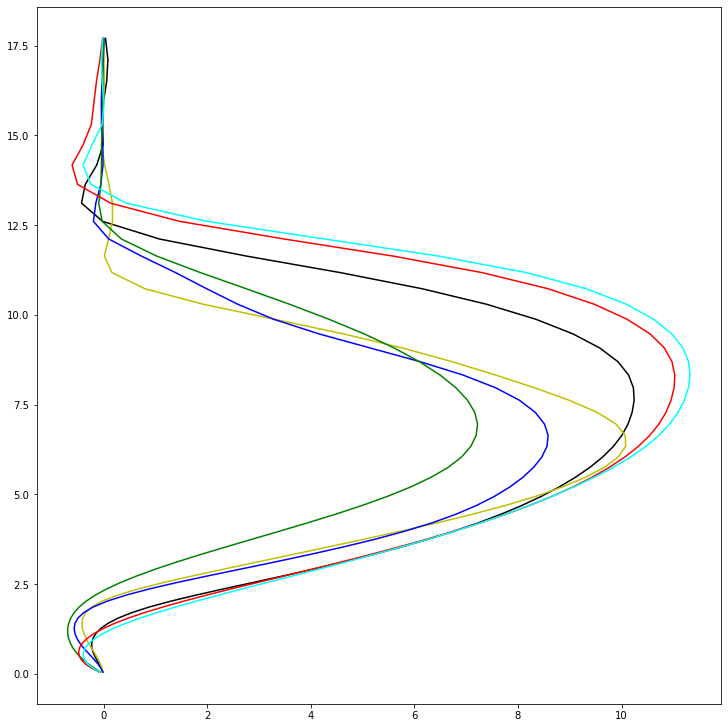

In [8]:
fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))

ax.plot(wprofile_q14.mean(axis=1), zh_q14, color='k')
ax.plot(wprofile_q11.mean(axis=1), zh_q14, color='y')
ax.plot(wprofile_q12.mean(axis=1), zh_q14, color='b')
ax.plot(wprofile_q13.mean(axis=1), zh_q14, color='g')
ax.plot(wprofile_q15.mean(axis=1), zh_q14, color='r')
ax.plot(wprofile_q16.mean(axis=1), zh_q14, color='cyan')
